# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 11.5

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [1]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [5]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: DummyClassifier (со стратегией uniform) предсказывает вероятность положительного класса. Так как он dummy, он, конечно, предсказывает всем вероятность 0.5

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [6]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


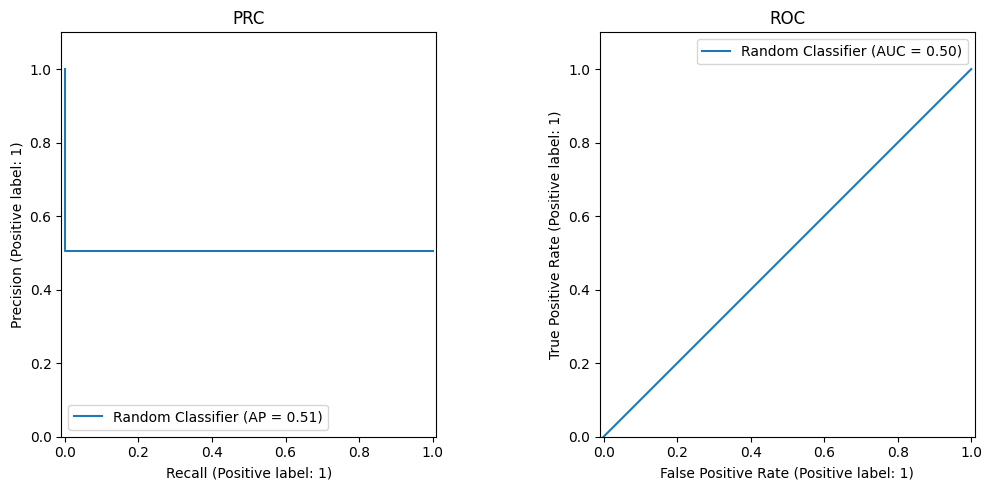

In [7]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None, linestyle="solid"):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name, linestyle=linestyle)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)
    
    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name, linestyle=linestyle)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [8]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [10]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([4232, 4268]))

In [11]:
from sklearn.svm import LinearSVC

C_values = np.logspace(-2, 2, 20)

fits = {}
for C in C_values:
    svm = LinearSVC(C=C)
    svm_model = svm.fit(X_train, y_train)
    fits[C] = average_precision_score(y_val, svm_model.predict(X_val))

best_fit = max(fits.items(), key=lambda item: item[1])
best_fit

(np.float64(0.01), np.float64(0.6978607909338551))

  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

SVM Model metrics
AUC-PR: 0.7169
AUC-ROC: 0.7753


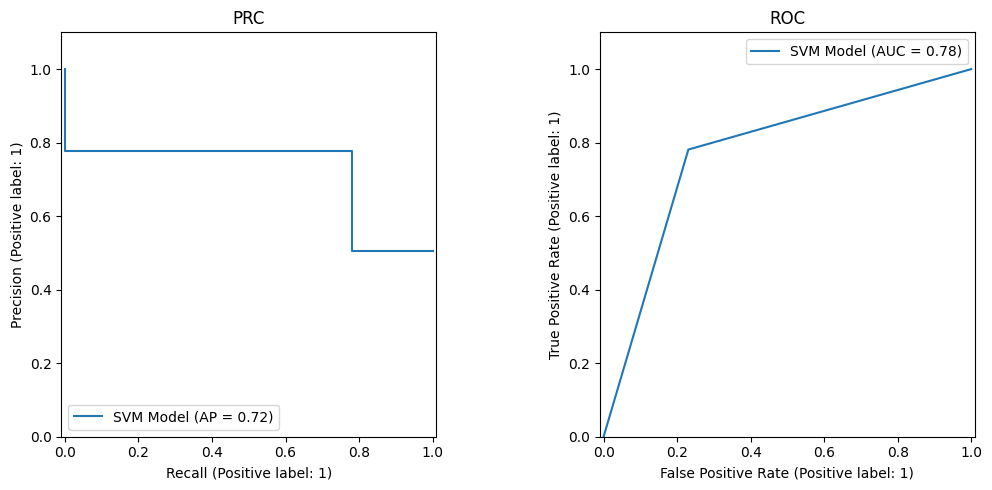

In [12]:
C = best_fit[0]
svm_model = LinearSVC(C=C).fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

depict_pr_roc(y_test, svm_pred, classifier_name="SVM Model")

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

**Ответ**:
- ROC-кривая явно свидетельствует в пользу того, что модель отсортировала объекты по уверенности следующим образом: сначала (сверху при сортировке) идёт один "кластер", в котором примерно 80% наблюдений обладают положительным классом; затем второй кластер, в котором положительных объектов уже меньше половины. При этом внутри "кластеров" объекты перемешаны равномерно, поэтому наклон внутри каждого из участков стабилен
- PR-кривая тоже подтверждает это. Сначала (при спуске порога) мы находимся в той части объектов, где преобладают положительные, и precision стабильно равен ~0.8 (в силу перемешанности). Двигаясь по нему, мы только постепенно увеличиваем recall, т.к. включаем всё больше положительных объектов относительно их общей доли. Затем мы резко попадаем во вторую часть, где доля положительных объектов меньше половины - и precision стабилизируется на новом, более низком уровне.

Может показаться, что PR-кривая монотонно невозрастает - но, скорее всего, это не так. Двигаясь порогом по каждой из двух стабильных групп объектов мы поочередно включаем как TP, так и FP. В силу перемешиванности на дистанции пропорция примерно сохраняется, но в моменте при включении очередного TP precision немного возрастает (как и recall).
ROC-кривая же монотонна в силу своих фундаментальных свойств.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

**Комментарий**: наша модель значительно лучше.

Random Model metrics
AUC-PR: 0.5150
AUC-ROC: 0.5181


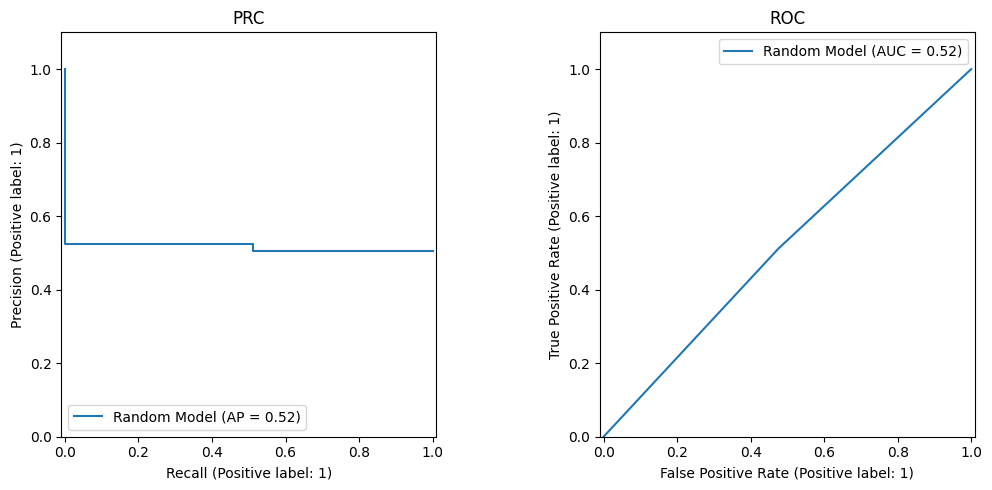

In [13]:
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
random_pred = random_classifier.predict(X_test)

depict_pr_roc(y_test, random_pred, classifier_name="Random Model")

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [14]:
from sklearn.linear_model import LogisticRegression

C_values = np.logspace(-2, 2, 20)

log_fits = {}
for C in C_values:
    logit = LogisticRegression(C=C)
    logit_model = logit.fit(X_train, y_train)
    log_fits[C] = average_precision_score(y_val, logit_model.predict(X_val))

best_log_fit = max(log_fits.items(), key=lambda item: item[1])
best_log_fit

(np.float64(0.18329807108324356), np.float64(0.6978607909338551))

Logit Model metrics
AUC-PR: 0.7172
AUC-ROC: 0.7756


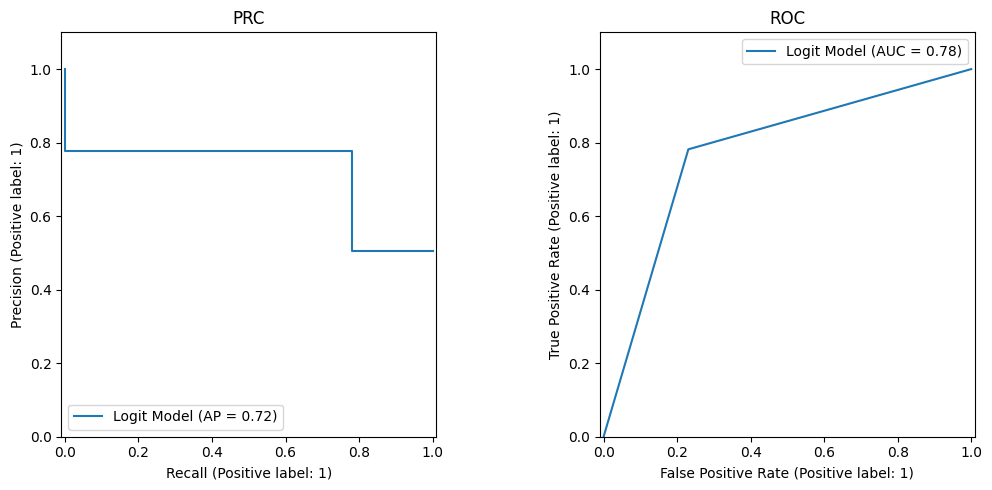

In [15]:
C = best_log_fit[0]
logit_model = LogisticRegression(C=C).fit(X_train, y_train)
logit_pred = logit_model.predict(X_test)

depict_pr_roc(y_test, logit_pred, classifier_name="Logit Model")

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

SVM metrics
AUC-PR: 0.7169
AUC-ROC: 0.7753
LR metrics
AUC-PR: 0.7172
AUC-ROC: 0.7756
Random metrics
AUC-PR: 0.5150
AUC-ROC: 0.5181


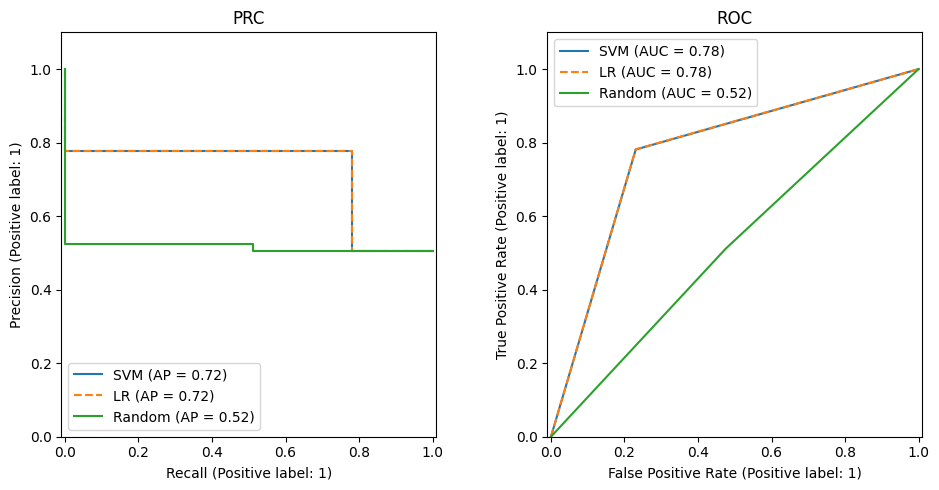

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

depict_pr_roc(y_test, svm_pred, ax=axes, classifier_name="SVM")
depict_pr_roc(y_test, logit_pred, ax=axes, classifier_name="LR", linestyle="dashed")
depict_pr_roc(y_test, random_pred, ax=axes, classifier_name="Random")

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** LR и SVM не отличаются на наших данных.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [17]:
X_sim, y_sim = make_classification(n_samples=300,
                                   n_features=2,
                                   n_classes=2,
                                   n_informative=2,
                                   n_redundant=0,
                                   random_state=179)

svm_sim = LinearSVC().fit(X_sim, y_sim)

(300, 2) (300,)


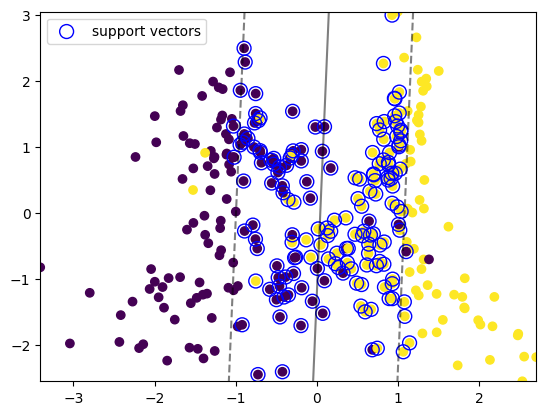

In [18]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    w = model.coef_[0]
    w_0 = model.intercept_[0]
    Z = w[1] * YY - w[0] * XX - w_0

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    print(X.shape, y.shape)
    plt.scatter(
        x=X[:,0],
        y=X[:,1],
        c=y
    )

    # Отрисовали опорные векторы
    decision_function = model.decision_function(X)
    support_vector_indices = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
    
    if plot_support:
        plt.scatter(
            x=X[support_vector_indices][:,0],
            y=X[support_vector_indices][:,1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X_sim, y_sim, svm_sim)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** те, что попадают в интервал +-1 от линии, по которой проходит разграничение классов

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

Использованный источник: https://scikit-learn.org/1.5/auto_examples/svm/plot_linearsvc_support_vectors.html

In [19]:
lr_sim  = LogisticRegression().fit(X_sim, y_sim)

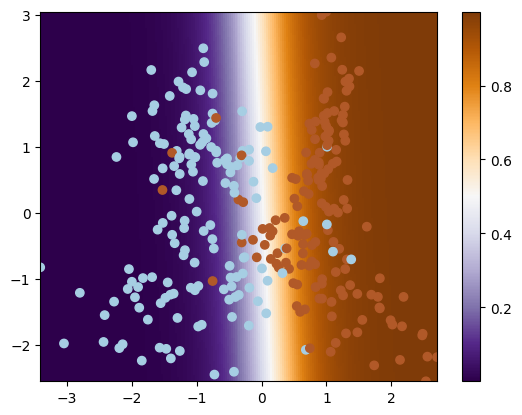

In [20]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 200)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 200)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    #return xy
    Z = model.predict_proba(xy)[:,1]
    Z = Z.reshape((xx.shape[0], -1)).T
    #print(Z)

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )

    #Отрисовали выборку
    plt.scatter(
        x=X[:,0],
        y=X[:,1],
        c=y,
        cmap=plt.cm.Paired
    )

    plt.colorbar(image)

plot_logreg_2D(X_sim, y_sim, lr_sim)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** эта область (белый цвет) имеет форму линии. Бинарная логистическая регрессия (как и все модели классификации, с которыми мы пока сталкивалсиь) подразумевает, что пространство разделяется гиперплоскотью, положение относительно которой и определяет принадлежность объекта к тому или иному классу. А расстояние от объекта до гиперплоскости, пропорциональное скалярному произведению вектора нормали плоскости и вектора с признаками объекта, говорит о степени уверенности отнесения к классу. Объекты, расположенные рядом с разделяющей гиперплоскостью (или тем более прямо на ней) имеют низкую уверенность быть отнесёнными как к положительному классу, так и к отрицательному, поэтому $p(y=+1|x) = 0.5$

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [21]:
def plot_calibration_curve(y_test, preds, model_name, ax=None):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))

    if ax == None:
        plt.figure(figsize=(6,6))
        ax = plt
    plt.plot(bin_middle_points, bin_real_ratios, label=model_name)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=102)

C:\Users\vadim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\vadim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


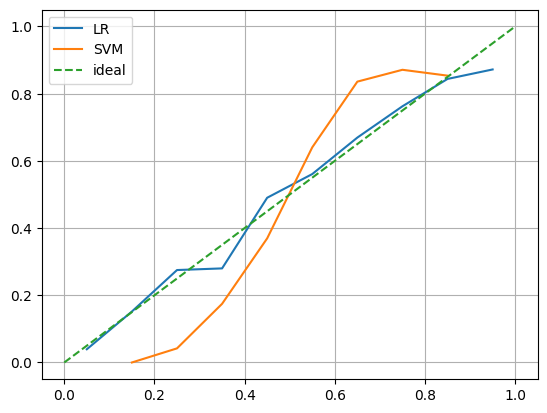

In [23]:
from scipy.special import expit
from sklearn.svm import SVC

#svm_model = SVC(kernel='linear', probability=True, shrinking=False).fit(X_train, y_train)
svm_model = LinearSVC().fit(X_train, y_train)
logit_model = LogisticRegression().fit(X_train, y_train)

LR_probs = logit_model.predict_proba(X_test)[:,1]
#SVM_probs = svm_model.predict_proba(X_test)[:,1]
SVM_probs = expit(svm_model.decision_function(X_test))

ax = plt.gca()
plot_calibration_curve(y_test, LR_probs, "LR", ax)
plot_calibration_curve(y_test, SVM_probs, "SVM", ax)

ax.plot(np.linspace(0, 1, 5), np.linspace(0, 1, 5), linestyle="dashed", label="ideal")

ax.grid()
ax.legend()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** кривая для LR откалибрована хорошо - она близка к диагонали, то есть в отрезке, соответствующем вероятности $p_i$, доля объектов с положительным классом действительно $\approx p_i$. Такого результата и стоило ожидать исходя из того, что логистическая регрессия оценивает условные вероятности принадлежности к классу. Метод SVM же хуже откалиброван - наблюдаются участки, где доля положительных объектов больше/меньше предсказанной "вероятности". Это логично, ведь SVM не пытается оценивать условные вероятности, и числа из интервала $[0, 1]$ в случае SVM искусственно получены преобразованием из расстояния от объекта до прямой - они и не являются вероятностями ни в каком смысле кроме того, что лежает между 0 и 1.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [24]:
from sklearn.metrics import log_loss, brier_score_loss

print('Log-loss:')
print(f'LR: {log_loss(y_test, LR_probs)}, SVM: {log_loss(y_test, SVM_probs)}', end='\n'*2)

print('Brier Score Loss:')
print(f'LR: {brier_score_loss(y_test, LR_probs)}, SVM: {brier_score_loss(y_test, SVM_probs)}')

Log-loss:
LR: 0.5005924180979006, SVM: 0.5567176613257502

Brier Score Loss:
LR: 0.16291734529189253, SVM: 0.18525909474529134


**Вывод**: логистическая регрессия выигрывает по обеим метрикам. Повторимся, это неудивительно, учитывая, что за логистической регрессией лежит идея оценок вероятностей, а за SVM - геометрические соображения.

Изучите распределение ответов классификаторов при помощи гистограмм

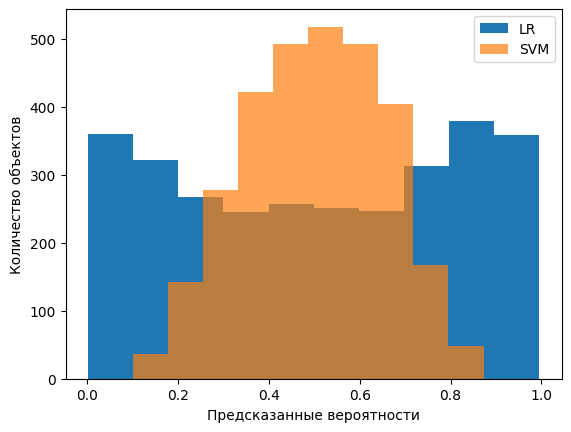

In [25]:
plt.hist(LR_probs, alpha=1, label="LR")
plt.hist(SVM_probs, alpha=0.7, label="SVM")

plt.xlabel("Предсказанные вероятности")
plt.ylabel("Количество объектов")
plt.legend()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** логистическая регрессия предсказывает вероятности принадлежности к классу, поэтому гистограмма, по сути, отражает реальное распределение вероятностей. Гистограмма для SVM напоминает нормальное распределение, очень маленькие и очень большие вероятности отсутствуют. Чтобы получить эти вероятности, мы по сути взяли расстояния до прямой (числитель без знаменателя) и прогнали через сигмоиду. Отступы на наших данных таковы, что при передаче в сигмоиду они в основном отображаются во что-то в районе 0.5. Искать в этом качественного смысла не стоит.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [26]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_svm = CalibratedClassifierCV(LinearSVC(), cv=5, method="sigmoid").fit(X_train, y_train)
c_svm_probs = calibrated_svm.predict_proba(X_test)[:,1]

print(f'Brier: {brier_score_loss(y_test, c_svm_probs)}, Log-loss: {log_loss(y_test, c_svm_probs)}')

Brier: 0.16295671804275877, Log-loss: 0.5003923000829797


C:\Users\vadim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\vadim\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


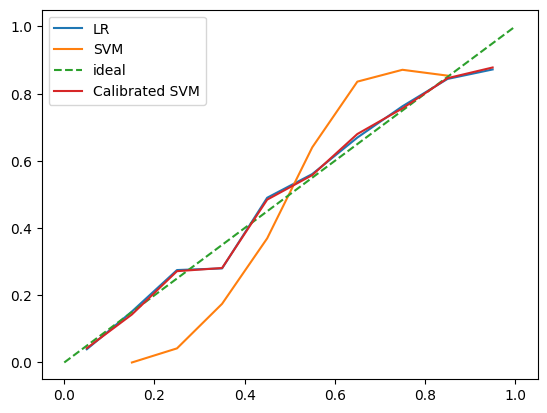

In [27]:
ax = plt.gca()

plot_calibration_curve(y_test, LR_probs, "LR", ax)
plot_calibration_curve(y_test, SVM_probs, "SVM", ax)

ax.plot(np.linspace(0, 1, 5), np.linspace(0, 1, 5), linestyle="dashed", label="ideal")

plot_calibration_curve(y_test, c_svm_probs, "Calibrated SVM", ax)

ax.grid()
ax.legend()
plt.show()

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** по метрикам и по калибровочкной кривой мы видим, что качество сталоо неотличимо от логистической регрессии.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [28]:
from scipy.optimize import minimize

svm_to_calibrate = LinearSVC().fit(X_train, y_train)

N_plus = len(y_train[y_train == 1])
N_minus = len(y_train[y_train == 0])

def PlattLikelihood(params):
    a, b = params[0], params[1]
    pred = svm_to_calibrate.decision_function(X_train)
    sig_pred = expit(a * pred + b)
    return -np.sum(y_train * np.log(sig_pred + 10e-10) + (1 - y_train) * np.log(1 - sig_pred + 10e-10))

optimization = minimize(PlattLikelihood, x0=(1, 1))
a, b = optimization.x[0], optimization.x[1]

platt = lambda x: expit(a*x + b)    

calibrated_probs = platt(svm_to_calibrate.decision_function(X_test))
print(f'Brier: {brier_score_loss(y_test, calibrated_probs)}, Log-loss: {log_loss(y_test, calibrated_probs)}')

Brier: 0.16296411357118706, Log-loss: 0.5006348272485436


**Комментарий:** я воспользовался калибровкой Платта, суть которой в том, чтобы отображать "логиты" в вероятности с помощью сигмоидальной функции вида $$p_i = \frac{1}{1+e^{-aq(x_i)-b}} = \sigma(aq(x_i) + b),$$ где $q(x_i)$ - выдача модели, а $a$ и $b$ - параметры. Для подбора параметров максимизируем функцию правдоподобия, записанную в методе PlattLikelihood.

Так как эта же калибровка по умолчанию исполоьзуется в `CalibratedClassifierCV`, мы получили такие же значения метрик. Это свидиетельствует о том, что эта реализация работает.

Использованный источник: https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [29]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

C:\Users\vadim\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [50]:
# Прочитаем датасет
df = pd.read_csv(path).drop(columns=['ID'])

numeric = ['Income', 'Children', 'Cars', 'Age']
categorical = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']

# Заменим пропуски категориальных переменных
df[categorical] = df[categorical].fillna('undefined')

# Отделим X и y
X = df.drop(columns=['Purchased Bike'])
y = np.where(df['Purchased Bike'] == 'Yes', 1, 0)

# Разделим на категориальные признаки и числовые
X_numeric = X[numeric]
X_categorical = X[categorical]

В начале поработаем только с категориальными признаками

In [51]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

AUC-PR: 0.5047
LR + Ordinal metrics
AUC-PR: 0.5047
AUC-ROC: 0.5446
CPU times: total: 109 ms
Wall time: 162 ms


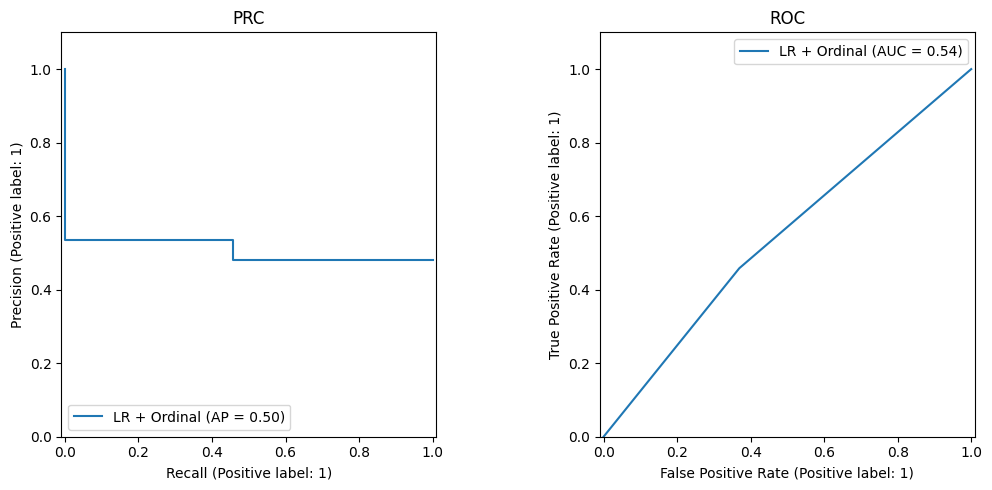

In [33]:
%%time
ordinal_encoder = OrdinalEncoder()

pipeline = Pipeline([
    ('encoder', ordinal_encoder),
    ('LR', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)

pred = model.predict(X_test)

print('AUC-PR: %.4f' % average_precision_score(y_test, pred))
depict_pr_roc(y_test, pred, classifier_name='LR + Ordinal')

#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

AUC-PR: 0.5612
LR + OHE metrics
AUC-PR: 0.5612
AUC-ROC: 0.6272
CPU times: total: 78.1 ms
Wall time: 169 ms


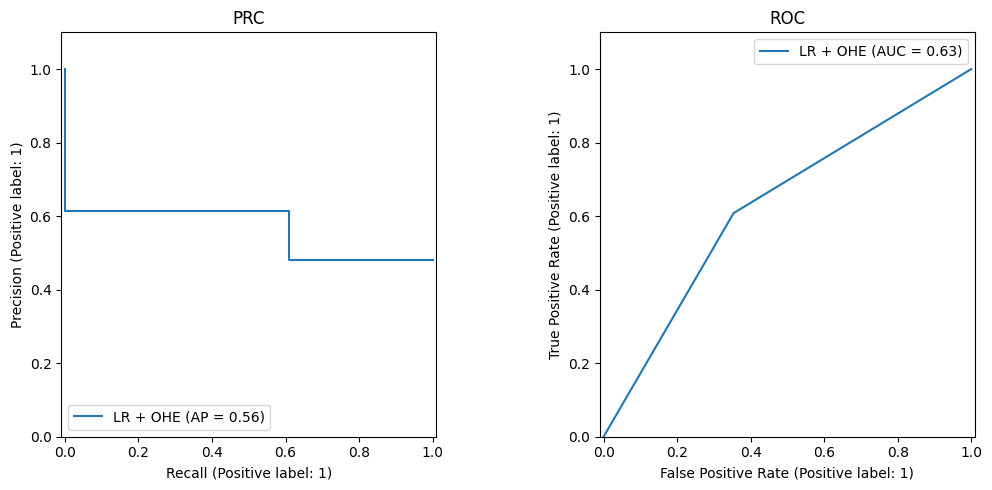

In [34]:
%%time
ohe_encoder = OneHotEncoder()

pipeline = Pipeline([
    ('encoder', ohe_encoder),
    ('LR', LogisticRegression())
])

model = pipeline.fit(X_train, y_train)

pred = model.predict(X_test)

print('AUC-PR: %.4f' % average_precision_score(y_test, pred))
depict_pr_roc(y_test, pred, classifier_name='LR + OHE')

Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [35]:
%%time
df_mte = df[categorical].copy(deep=True)
df_mte['Purchased Bike'] = y

for var in categorical:
    df_mte[var] = df_mte.groupby(var)['Purchased Bike'].transform('mean')

df_mte.loc[X_train.index]

df_mte_x = df_mte.drop(columns=['Purchased Bike'])
df_mte_y = df_mte['Purchased Bike']

X_train_mte = df_mte_x.loc[X_train.index]
y_train_mte = df_mte_y.loc[X_train.index]
X_test_mte = df_mte_x.loc[X_test.index]
y_test_mte = df_mte_y.loc[X_test.index]

model = LogisticRegression().fit(X_train_mte, y_train_mte)

mte_pred = model.predict(X_test_mte)
average_precision_score(y_test, mte_pred)

CPU times: total: 15.6 ms
Wall time: 31.9 ms


np.float64(0.5854903846153846)

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [218]:
from sklearn.base import BaseEstimator, TransformerMixin

class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, noise_level=0, features=None):
        self.features = features
        self.values_by_feature = {}
        self.noise_level = noise_level

    def fit(self, X,  y, features=None):
        if not features:
            features = X.columns
        self.features = features

        X = X.copy()
        X['y'] = y
        for f in features:
            values = X.groupby(f)['y'].mean()
            self.values_by_feature[f] = values

        return self

    def transform(self, X):
        X = X.copy()
        for f in self.features:
            #print(self.values_by_feature[f])
            X[f] = X[f].replace(self.values_by_feature[f].to_dict())
            if self.noise_level > 0:
                X[f] = X[f] * (1 + self.noise_level * np.random.randn(len(X[f])))
            
        return X

mte = MeanTargetEncoder().fit(X_train, y_train)
mte.transform(X_test)

,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age
912,0.40327,0.5,0.560748,0.554348,0.464088,0.496063,0.463736,0.580808,0.482759,0.412104,0.407407
617,0.40327,0.469914,0.560748,0.400000,0.412698,0.461957,0.463736,0.350195,0.53913,0.412104,0.285714
200,0.573209,0.469914,0.484375,0.497382,0.58794,0.530726,0.521552,0.379310,0.53913,0.61194,0.352941
749,0.40327,0.5,0.562500,0.466258,0.464088,0.530726,0.463736,0.580808,0.53913,0.412104,0.454545
497,0.573209,0.5,0.562500,0.608696,0.511278,0.530726,0.463736,0.598870,0.53913,0.412104,0.619048
...,...,...,...,...,...,...,...,...,...,...,...
574,0.573209,0.5,0.348485,0.497382,0.58794,0.442478,0.463736,0.580808,0.482759,0.412104,0.619048
800,0.573209,0.469914,0.484375,0.400000,0.58794,0.530726,0.463736,0.350195,0.53913,0.412104,0.482759
843,0.573209,0.469914,0.348485,0.466258,0.235294,0.461957,0.521552,0.350195,0.482759,0.412104,0.625000
235,0.40327,0.5,0.384615,0.608696,0.511278,0.496063,0.463736,0.598870,0.570881,0.516746,0.000000


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [37]:
pd.set_option('future.no_silent_downcasting', True)

In [52]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=10)

In [149]:
results_zero_noise = {}

for C in [0] + np.logspace(-3, 1, 20):
    model = Pipeline([
        ('mte', MeanTargetEncoder(noise_level=0)),
        ('LR', LogisticRegression(C=C))
    ])

    model.fit(X_train, y_train)
    
    results_zero_noise[(C, noise_level)] = average_precision_score(y_val, model.predict(X_val))

best_zero_noise = max(results_zero_noise.items(), key=lambda item: item[1])

best_c, best_noise = best_zero_noise[0]

model = Pipeline([
            ('mte', MeanTargetEncoder(noise_level=best_noise)),
            ('LR', LogisticRegression(C=best_c))
        ])

model.fit(X_train, y_train)
average_precision_score(y_test, model.predict(X_test))

np.float64(0.5411601731601732)

In [150]:
results = {}

for noise_level in np.logspace(-3, 1, 20):
    for C in [0] + np.logspace(-3, 1, 20):
        model = Pipeline([
            ('mte', MeanTargetEncoder(noise_level=noise_level)),
            ('LR', LogisticRegression(C=C))
        ])
        
        model.fit(X_train, y_train)
    
        results[(C, noise_level)] = average_precision_score(y_val, model.predict(X_val))

best = max(results.items(), key=lambda item: item[1])

In [151]:
best_c, best_noise = best[0]

model = Pipeline([
            ('mte', MeanTargetEncoder(noise_level=best_noise)),
            ('LR', LogisticRegression(C=best_c))
        ])

model.fit(X_train, y_train)
average_precision_score(y_test, model.predict(X_test))

np.float64(0.572090909090909)

**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** # your answer here

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [ ]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding

In [220]:
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, noise_level=0, smooth=0, features=None):
        self.features = features
        self.values_by_feature = {}
        self.noise_level = noise_level
        self.smooth = smooth

    def fit(self, X,  y):
        if not self.features:
            self.features = X.columns

        global_mean = np.mean(y)

        X = X.copy()
        X['y'] = y
        for f in self.features:
            agg = X.groupby(f)['y'].agg(['sum', 'count'])
            self.values_by_feature[f] = (agg['sum'] + self.smooth*global_mean) / (agg['count'] + self.smooth)
        
        return self

    def transform(self, X):
        X = X.copy()
        for f in self.features:
            #print(self.values_by_feature[f])
            X[f] = X[f].replace(self.values_by_feature[f].to_dict())
            if self.noise_level > 0:
                X[f] = X[f] * (1 + self.noise_level * np.random.randn(len(X[f])))
            
        return X

In [152]:
model = Pipeline([
            ('mte', MeanTargetEncoder(smooth=0.1)),
            ('LR', LogisticRegression())
        ])

model.fit(X_train, y_train)
average_precision_score(y_test, model.predict(X_test))

np.float64(0.5928298368298368)

#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



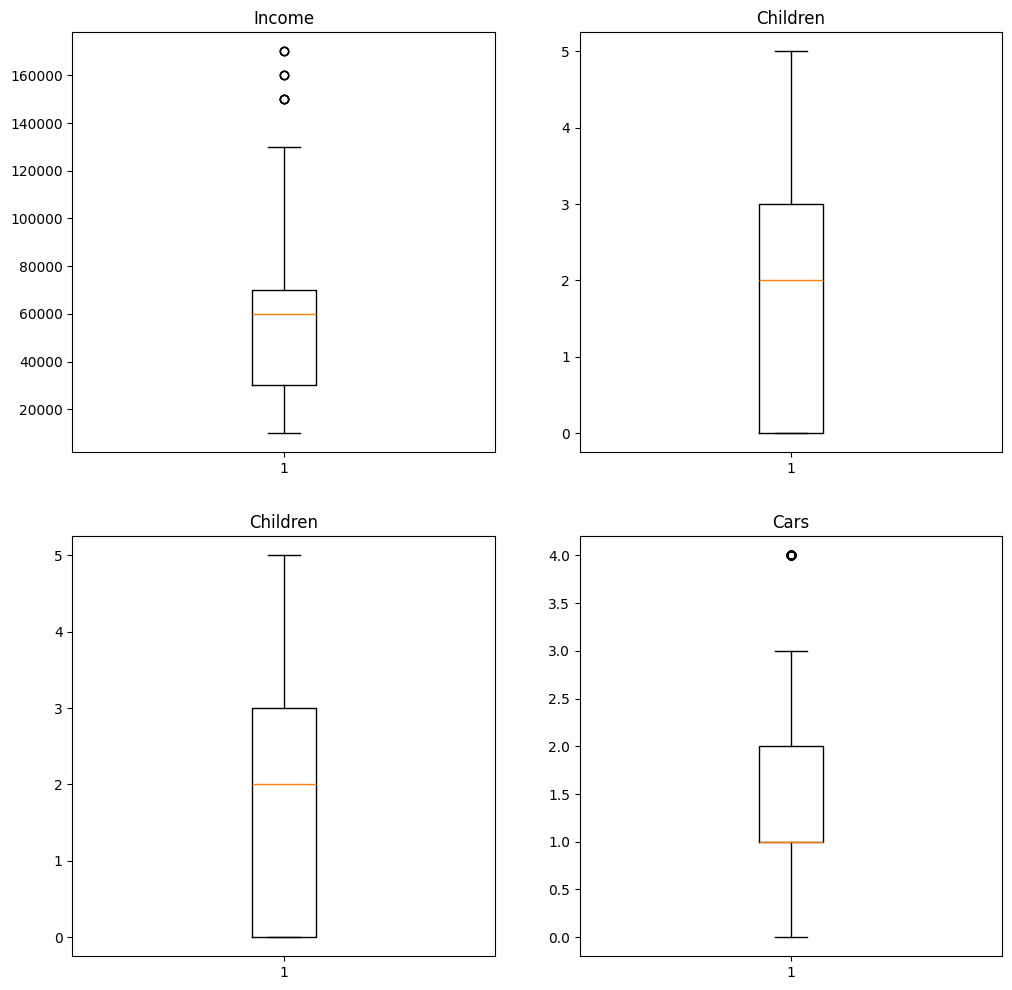

In [185]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for i in range(2):
    for j in range(2):
        f = numeric[i+j]
        axes[i][j].boxplot(X[f][X[f].notna()])
        axes[i][j].set_title(f)

X_1 = X[(X['Income'] < 140000) & (X['Cars'] < 3.5)]
y_1 = y[X_1.index]

X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.25, random_state=777, stratify=y_1)

Данных совсем немного, поэтому среднее может быть искажено даже после удаления выбросов. Медиана более устойчива на маленьких выборках, поэтому заполним пропуски ей.

In [192]:
X_train[numeric] = X_train[numeric].fillna(X_train[numeric].median())
X_test[numeric] = X_test[numeric].fillna(X_test[numeric].median())
X_train

,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age
904,Single,Female,60000.0,2.0,Bachelors,Skilled Manual,No,0.0,0-1 Miles,North America,36.0
983,Married,Male,130000.0,2.0,Graduate Degree,Management,Yes,2.0,0-1 Miles,North America,41.0
744,Married,Female,70000.0,4.0,Partial College,Professional,Yes,1.0,10+ Miles,North America,56.0
360,Single,Male,130000.0,0.0,Graduate Degree,Management,Yes,0.0,2-5 Miles,Pacific,48.0
143,Married,Female,80000.0,0.0,Bachelors,Professional,Yes,3.0,10+ Miles,Pacific,32.0
...,...,...,...,...,...,...,...,...,...,...,...
554,Married,Female,60000.0,2.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,43.0
813,Married,Female,70000.0,2.0,High School,Professional,Yes,2.0,10+ Miles,North America,53.0
63,Single,Male,60000.0,4.0,Bachelors,Professional,Yes,3.0,10+ Miles,Pacific,41.0
353,Single,Male,40000.0,0.0,Graduate Degree,Clerical,No,0.0,0-1 Miles,Europe,38.0


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [229]:
model = Pipeline([
            ('mte', MeanTargetEncoder(features=categorical+numeric, smooth=8)),
            ('LR', LogisticRegression())
        ])
model.fit(X_train, y_train)

average_precision_score(y_test, model.predict(X_test))

np.float64(0.560079326701667)

Лучше не стало

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ 
- плюсы: более компактно хранят информацию; датасет после кодирования уже содержит информацию о том, какие значения признака скорее дают увеличение вероятности положительного класса, а какие - нет, и можно понять это визуально;
- минусы: необходимо подбирать лишний гиперпараметр для сглаживания

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [231]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

"wget" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [233]:
import urllib.request
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
filename = 'data.csv'
urllib.request.urlretrieve(url, filename)

('data.csv', <http.client.HTTPMessage at 0x27368afd0a0>)

In [479]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('data.csv', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df['sex'] = np.where((df['sex'] == ' Male'), 0, 1)
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
10421,38,Private,234901,Some-college,10,Married-civ-spouse,Prof-specialty,Husband,White,0,0,0,40,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [480]:
X = df.drop(columns=['income'])
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [481]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race','native-country']
numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week',]

transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(), categorical),
        ('normalize', StandardScaler(), numerical)
    ],
    remainder='passthrough'
)

transformer.fit_transform(X_train)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 325518 stored elements and shape (24420, 107)>

Получим суммарно 107 признаков, то есть 107-14 = 93 новых \
**Комментарий**: сразу делаю нормализацию, т.к. иначе дальше оптимизатор не может найти минимум функции потерь

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

0.5425309535002445
Some Classifier metrics
AUC-PR: 0.5425
AUC-ROC: 0.7671


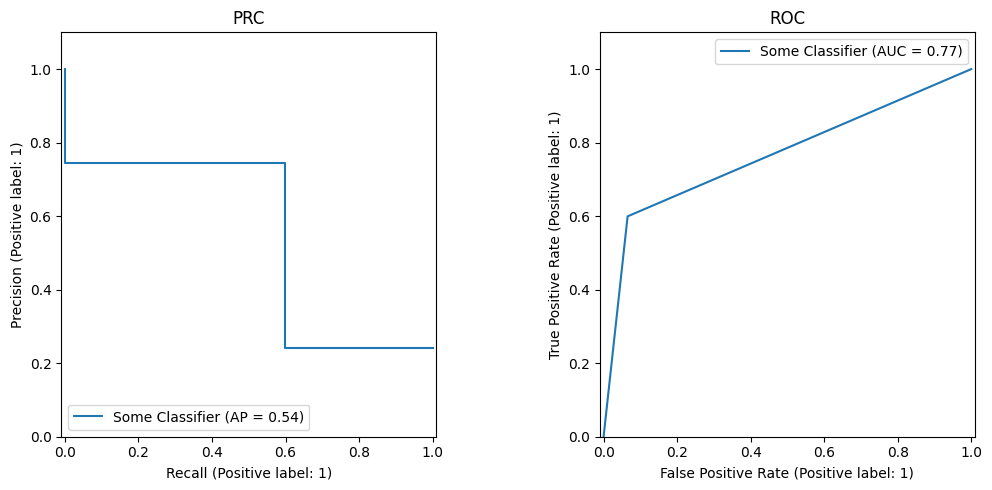

In [482]:
model = Pipeline([
    ('OHE_transformer', transformer),
    ('LR', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)

print(average_precision_score(y_test, model.predict(X_test)))
depict_pr_roc(y_test, model.predict(X_test))

Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [483]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [484]:
X_train.shape, X_val.shape, X_test.shape

((19536, 14), (4884, 14), (8141, 14))

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [486]:
top_40_ind = np.argpartition(np.abs(model['LR'].coef_), -40)[0][-40:]

transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse_output=False), categorical),
        ('normalize', StandardScaler(), numerical)
    ],
    remainder='passthrough'
)

X_train_40 = pd.DataFrame(transformer.fit_transform(X_train)).iloc[:, top_40_ind]
X_test_40 = pd.DataFrame(transformer.transform(X_test)).iloc[:, top_40_ind]

LR_top_40 = LogisticRegression().fit(X_train_40, y_train)

print(average_precision_score(y_test, LR_top_40.predict(X_test_40)))

0.5159279402986048


Изменилось ли качество? Как?

**Ответ**: качество ухудшилось, но незначительно. Относительно того, как много признаков мы удалили, это успех.

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [494]:
transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse_output=False), categorical)
    ],
    remainder='passthrough'
)

model_un = Pipeline([
    ('OHE_transformer', transformer),
    ('LR', LogisticRegression(max_iter=1000))
])
model_un = model_un.fit(X_train, y_train)
print(average_precision_score(y_test, model_un.predict(X_test)))

np.argpartition(np.abs(model_un['LR'].coef_), -40)[0][-40:]

X_train_40 = pd.DataFrame(model_un['OHE_transformer'].transform(X_train)).iloc[:, top_40_ind]
X_test_40 = pd.DataFrame(model_un['OHE_transformer'].transform(X_test)).iloc[:, top_40_ind]

LR_top_40 = LogisticRegression().fit(X_train_40, y_train)

print(average_precision_score(y_test, LR_top_40.predict(X_test_40)))

0.5076755215043494
0.48753138262768014


C:\Users\vadim\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Ответ**: без нормализации качество ухудшается после отсеивания признаков, пусть и незначительно. Само по себе (до отсеивания) качество тоже хуже. Значит, нормализация была хорошей идеей.

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [518]:
transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse_output=False), categorical),
    ],
    remainder='passthrough'
)

model_ohe_scale = Pipeline([
    ('ohe', transformer),
    ('normalize', StandardScaler()),
    ('LR', LogisticRegression(max_iter=1000))
])

model_ohe_scale.fit(X_train, y_train)
print(average_precision_score(y_test, model_ohe_scale.predict(X_test)))

top_40_ind = np.argpartition(np.abs(model_ohe_scale['LR'].coef_), -40)[0][-40:]

X_train_40 = pd.DataFrame(model_ohe_scale['normalize'].transform(model_ohe_scale['ohe'].transform(X_train))).iloc[:, top_40_ind]
X_test_40 = pd.DataFrame(model_ohe_scale['normalize'].transform(model_ohe_scale['ohe'].transform(X_test))).iloc[:, top_40_ind]

LR_top_40 = LogisticRegression().fit(X_train_40, y_train)

print(average_precision_score(y_test, LR_top_40.predict(X_test_40)))

0.5416849886716462
0.5402089291602783


#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** как известно, корреляция - мера линейной взаимосвязи. Простыми словами, чем больше зависимость между двумя величинами поожа на линейную, тем ближе корреляция к 1 или -1. Очевидно, признаки с модулем корреляции с таргетом, близким к единице, очень важны, и будут значительно влиять на качество модели. Признаки же с корреляцией с таргетом в районе 0, наоборот, почти не содержат информации о таргете (покуда мы считаем зависимость между каждой переменной и таргетом линейной), и от них можно было бы отказаться. Дополнительно можно было бы сказать о корреляции между значенииями самих признаков - если она близка к 1, то признаки в некотором смысле дублируют друг друга и несут одну и ту же информацию. Среди сильно скоррелированных признаков можно оставить только 1 без сильных потерь в качестве.

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [602]:
%%time
transformer = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(sparse_output=False), categorical),
        ('normalize', Normalizer(), numerical)
    ],
    remainder='passthrough'
)

ohe_result = pd.DataFrame(transformer.fit_transform(X_train))

corrs = []
for feature in ohe_result.columns:
    corrs.append(np.corrcoef(ohe_result[feature], y_train)[0][1].item())

CPU times: total: 62.5 ms
Wall time: 173 ms


In [603]:
%%time
top_40_corr = np.argpartition(np.abs(corrs), -40)[-40:]

X_train_40_corr = transformer.transform(X_train)[:, top_40_corr]
X_test_40_corr = transformer.transform(X_test)[:, top_40_corr]

LR_40_corr = LogisticRegression().fit(X_train_40_corr, y_train)
print(average_precision_score(y_test, LR_40_corr.predict(X_test_40_corr)))

0.49314151609094875
CPU times: total: 46.9 ms
Wall time: 350 ms


Качество примерно такое же, как и в случае с выбором топ-40 по коэфу.

В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [606]:
%%time
def t_statistic(a, b):
    mu_plus = np.mean(a)
    mu_minus = np.mean(b)
    var_plus = np.var(a)
    var_minus = np.var(b)
    n_plus = len(a)
    n_minus = len(b)

    return np.abs(mu_plus - mu_minus) / np.sqrt((n_plus*var_plus + n_minus*var_minus) / (n_plus + n_minus))



transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical),
        ('ohe', OneHotEncoder(sparse_output=False), categorical)
    ],
    remainder='passthrough'
)
transformer.fit(X_train)

X_plus = X_train[y_train == 1]
X_minus = X_train[y_train == 0]

ohe_result_plus = pd.DataFrame(transformer.transform(X_plus))
ohe_result_minus = pd.DataFrame(transformer.transform(X_minus))

t_stats = []
for f in ohe_result_plus.columns:
    t_stats.append(t_statistic(ohe_result_plus[f], ohe_result_minus[f]))

top_40_ttest = np.argpartition(np.abs(t_stats), -40)[-40:]

X_train_top_ttest = transformer.transform(X_train)[:, top_40_ttest]
X_test_top_ttest = transformer.transform(X_test)[:, top_40_ttest]

model_ttest = LogisticRegression().fit(X_train_top_ttest, y_train)
average_precision_score(y_test, model_ttest.predict(X_test_top_ttest))

CPU times: total: 156 ms
Wall time: 503 ms


np.float64(0.5242128581568859)

#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

**Комментарий**: обратим внимание на то, что проводить отсев признаков итеративно любым из вышепредставленных способов, кроме построения регрессии и оценки модулей коэффициентов - бессмысленно, ведь от последоваательного удаления фич значения, например, корреляций других фич с таргетом, изменяться никак не будут. Аналогично обстоит с t-статистиками. \
Значит, будем строить регрессию и смотреть на коэффициенты.

In [715]:
m = 40

transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical),
        ('ohe', OneHotEncoder(sparse_output=False), categorical)
    ],
    remainder='passthrough'
)

k_scores = {}
for k in range(1, 100):
    ohe_x_train = transformer.fit_transform(X_train)
    ohe_x_test = transformer.transform(X_test)
    
    while ohe_x_train.shape[1] - k >= m:
        lr = LogisticRegression()
        lr.fit(ohe_x_train, y_train)
        worst_k = np.argpartition(np.abs(lr.coef_[0]), k)[:k]
        ohe_x_train = np.delete(ohe_x_train, worst_k, axis=1)
        ohe_x_test = np.delete(ohe_x_test, worst_k, axis=1)
    
    model = LogisticRegression()
    model.fit(ohe_x_train, y_train)
    
    k_scores[k] = average_precision_score(y_test, model.predict(ohe_x_test))

In [717]:
max(k_scores.items(), key=lambda item: item[1])

(68, np.float64(0.5430967181837543))

**Комментарий**: лучший результат дал k = 68. Но заметим, что это на самом деле всего одна итерация отсеивания. То есть, он просто сказал нам, что выгоднее всего единоразово убрать 68 худших признаков. А если мы всё таки хотим, чтобы итераций было хотя бы 2:

In [721]:
items = [item for item in k_scores.items() if item[0] <= 33] # 107 - 40 = 67. 67 // 2 = 33.
print(max(items, key=lambda item: item[1]))

(24, np.float64(0.5415611439301572))


В этом случае можно взять шаг 24, результат будет не сильно хуже. Это всё ещё довольно большой шаг - то есть, интуитивное соображение о том, что отсеивание по маленькому шагу должно дать точность выше, оказывается неверно.

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

**Комментарий**: этот метод наоборот подразумевает, что мы заранее знаем полезность всех признаков. 

In [742]:
m = 40

transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical),
        ('ohe', OneHotEncoder(sparse_output=False), categorical)
    ],
    remainder='passthrough'
)
transformer.fit(X_train)
ohe_x_train_initial = pd.DataFrame(transformer.transform(X_train))
ohe_x_test_initial = pd.DataFrame(transformer.transform(X_test))

lr = LogisticRegression()
lr.fit(ohe_x_train_initial, y_train)
coefs = lr.coef_[0]

for k in range(1, m+1):
    best_k = np.argpartition(coefs, -k)[-k:]
    ohe_x_train = ohe_x_train_initial[best_k]
    ohe_x_test = ohe_x_test_initial[best_k]
    lr = LogisticRegression()
    lr.fit(ohe_x_train, y_train)
    print(k, average_precision_score(y_test, lr.predict(ohe_x_test)))

1 0.36539571707874896
2 0.33479719276772724
3 0.33479719276772724
4 0.33479719276772724
5 0.3352241446301705
6 0.3352957047455714
7 0.40736828117204626
8 0.4063793472598697
9 0.505581933307913
10 0.5106684990572874
11 0.5106684990572874
12 0.5111005309453479
13 0.5117212049077704
14 0.5112293629137147
15 0.510886799218423
16 0.5111572108959662
17 0.5112293629137147
18 0.5029481689123496
19 0.5137182734444261
20 0.5125649922284243
21 0.5160030046632422
22 0.5233311112655245
23 0.529044185944796
24 0.529044185944796
25 0.5286947421820287
26 0.5293936772032255
27 0.534614204508708
28 0.5340640683366967
29 0.5324626346019348
30 0.5326595799506877
31 0.5331324117032051
32 0.5340350142037724
33 0.5316066948154188
34 0.5347384238297567
35 0.5331803454850679
36 0.5308719183466604
37 0.5308719183466604
38 0.5325062374546246
39 0.53242977746344
40 0.5311018402566177


Метрика растёт немонотонно, поэтому порогов можно выделить несколько. Более того, проблема в том, что при переходе от 1 к 2 признакам метрика упала так сильно, как дальше нигде не падала. То есть, если бы мы выставляли порог, мы могли бы легко провалиться в этот локальный минимум и остаться с ужасным качеством. \
В рамках 40 признаков лучший результат дало добавление вплоть до 34-го.

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** 
- Лучший результат показал простой отсев признаков по величине коэффициента в регрессии (причём в нашем случае оказалось неважно, итеративно делать это или нет)
- методы-фильтрации хороши тем, что можно один раз посчитать статистики, причем последние можно гибко выбирать под задачу, а затем комбинировать признаки как хотим, зная статистики для них. Но придётся подумать над выбором статистики
- методы-обёртки дают большую вариативность в выборке способов оценивания занчимости коэффициента, в шаге, выборе порога эпсилон и т.д. Наверное, потенциально это может позволить добиться наилучших результатов, но требует перебирать очень много параметров

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [752]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
#!unzip bank-additional.zip
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [753]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [754]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [983]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    return_metrics=[],
    client_max_revenue=None,
    coef_c=1,
    threshold=0.5
):
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    categorical = X.select_dtypes(include=['object']).columns.to_list()
    numerical = X.select_dtypes(include=['int', 'float']).columns.to_list()

    metrics = []
    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        X_train = X.loc[train_index]
        X_test = X.loc[test_index]
        y_train = y.loc[train_index]
        y_test = y.loc[test_index]
        transformer = ColumnTransformer(
            transformers=[
                ('scaler', StandardScaler(), numerical),
                ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
            ],
            remainder='passthrough')
        
        model = Pipeline([
            ('ohe_scale', transformer),
            ('LR', LogisticRegression(C=coef_c))
        ])
        model.fit(X_train, y_train)
        
        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        y_pred = (model.predict_proba(X_test)[:,1] >= threshold).astype(int)
        
        
        metric_dict = {
            'AUC_ROC': roc_auc_score(y_test, y_pred)
        }
        
        if 'profit' in return_metrics:
            costs = y_pred.sum() * 2
            revenue = ((y_pred * y_test) * (np.random.uniform(0, client_max_revenue, y_pred.shape[0])
                                                 if client_max_revenue != None else 10*np.ones(y_pred.shape[0]))).sum()
            metric_dict['costs'] = costs
            metric_dict['revenue'] = revenue
            metric_dict['profit'] = revenue - costs

        if 'pr' in return_metrics:
            TP = (y_pred * y_test).sum()
            FP = (y_pred * (1 - y_test)).sum()
            FN = ((1 - y_pred) * y_test).sum()

            metric_dict['precision'] = TP / (TP + FP)
            metric_dict['recall'] = TP / (TP + FN)
            
        metrics.append(metric_dict)
    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [985]:
cross_validate(X, y)

,AUC_ROC
0,0.500000
1,0.500000
2,0.500000
3,0.516388
4,0.617446


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [986]:
res1 = cross_validate(X, y, n_splits=10, shuffle=True, return_metrics=['profit'])
print('Средний профит', np.mean(res1['profit']))
print('Стандартное отклонение профита', np.std(res1['profit']))
print('Средние издержки', np.mean(res1['costs']))
print('Корреляция ROC_AUC и профита', np.corrcoef(res1['AUC_ROC'], res1['profit'])[0][1])

res1

Средний профит 737.8
Стандартное отклонение профита 90.1529810932506
Средние издержки 320.2
Корреляция ROC_AUC и профита 0.9046255015659294


,AUC_ROC,costs,revenue,profit
0,0.607098,318,1140.0,822.0
1,0.593349,286,910.0,624.0
2,0.611073,346,1060.0,714.0
3,0.614611,298,1060.0,762.0
4,0.597009,316,990.0,674.0
5,0.594647,300,930.0,630.0
6,0.611938,378,1150.0,772.0
7,0.608654,306,1110.0,804.0
8,0.598507,282,940.0,658.0
9,0.628255,372,1290.0,918.0


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [904]:
res2 = cross_validate(X, y,
                      n_splits=10,
                      shuffle=True,
                      return_metrics=['profit'],
                      client_max_revenue=20)

print('Средний профит', np.mean(res2['profit']))
print('Стандартное отклонение профита', np.std(res2['profit']))
print('Средние издержки', np.mean(res2['costs']))
print('Корреляция ROC_AUC и профита', np.corrcoef(res2['AUC_ROC'], res2['profit'])[0][1])

res2

Средний профит 766.1007323260494
Стандартное отклонение профита 152.81788228163504
Средние издержки 321.8
Корреляция ROC_AUC и профита 0.9476996957593841


,AUC_ROC,costs,revenue,profit
0,0.614986,332,1085.316490,753.316490
1,0.619915,332,1254.430742,922.430742
2,0.609830,302,1118.427699,816.427699
3,0.603424,324,1006.933431,682.933431
4,0.601103,280,957.819058,677.819058
5,0.614198,348,1261.463297,913.463297
6,0.630619,386,1425.953535,1039.953535
7,0.593714,310,965.620945,655.620945
8,0.599782,312,1028.296160,716.296160
9,0.587690,292,774.745967,482.745967


**Комментарий**: все средние, очевидно, сохранились (матожидание новой случайной величины = 10), немного возросло стандартное отклонение профита, что тоже понятно (теперь выручка с одного клиента тоже обладает ненулевой дисперсией)

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

In [911]:
grid = np.logspace(-2, 2, 20)
metrics_by_c = []
for c in grid:
    res3 = cross_validate(X, y,
                          n_splits=5,
                          shuffle=True,
                          return_metrics=['profit'],
                          client_max_revenue=20,
                          coef_c=c)
    metrics_by_c.append(res3['profit'].mean())

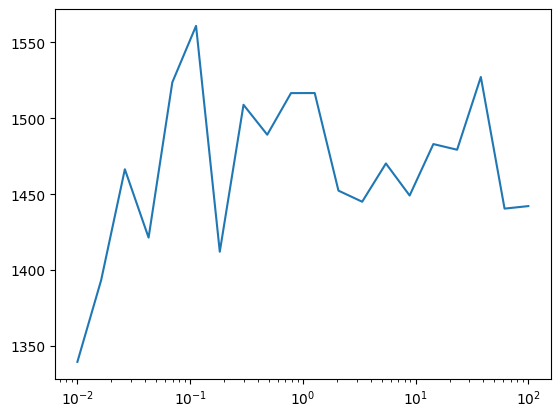

In [913]:
plt.plot(grid, metrics_by_c)
plt.xscale('log')

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

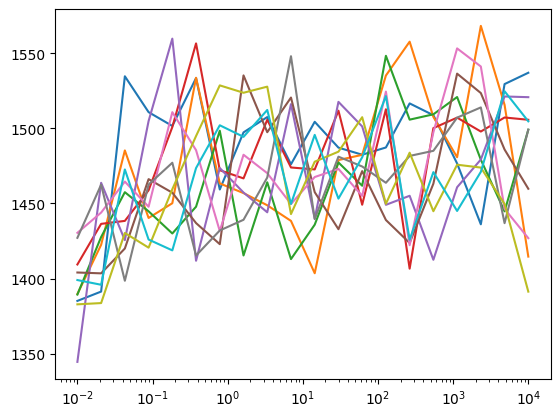

In [917]:
grid = np.logspace(-2, 4, 20)

for i in range(10):
    metrics_by_c = []
    for c in grid:
        res3 = cross_validate(X, y,
                              n_splits=5,
                              shuffle=True,
                              return_metrics=['profit'],
                              client_max_revenue=20,
                              coef_c=c)
        metrics_by_c.append(res3['profit'].mean())
    plt.plot(grid, metrics_by_c)
    plt.xscale('log')

Тенденций нет, разве что не стоит брать значения, близкие к 0. Оставим C=1

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ с удачной попытки мы в среднем получаем значительно больше, чем теряем с неудачной, поэтому было бы хорошо вычислить всех согласлных клиентов. Следовательно, нас будет интересовать хороший recall. Однако отношение дохода (его  матожидания) с удачного клиента и затрат на звонок - фиксировано, поэтому будет существовать нижний порог на precision, заступив за который мы точно получим отрицательную прибыль.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

In [931]:
threshold_grid = np.linspace(0, 1, 101)

results = []

for threshold in threshold_grid:
    res4 = cross_validate(X, y,
                          n_splits=5,
                          shuffle=True,
                          return_metrics=['profit', 'pr'],
                          client_max_revenue=20,
                          threshold=threshold)
    results.append(res4)

C:\Users\vadim\AppData\Local\Temp\ipykernel_8272\1864089513.py:63: RuntimeWarning: invalid value encountered in scalar divide
  metric_dict['precision'] = TP / (TP + FP)
C:\Users\vadim\AppData\Local\Temp\ipykernel_8272\1864089513.py:63: RuntimeWarning: invalid value encountered in scalar divide
  metric_dict['precision'] = TP / (TP + FP)
C:\Users\vadim\AppData\Local\Temp\ipykernel_8272\1864089513.py:63: RuntimeWarning: invalid value encountered in scalar divide
  metric_dict['precision'] = TP / (TP + FP)
C:\Users\vadim\AppData\Local\Temp\ipykernel_8272\1864089513.py:63: RuntimeWarning: invalid value encountered in scalar divide
  metric_dict['precision'] = TP / (TP + FP)
C:\Users\vadim\AppData\Local\Temp\ipykernel_8272\1864089513.py:63: RuntimeWarning: invalid value encountered in scalar divide
  metric_dict['precision'] = TP / (TP + FP)
C:\Users\vadim\AppData\Local\Temp\ipykernel_8272\1864089513.py:63: RuntimeWarning: invalid value encountered in scalar divide
  metric_dict['precision

In [963]:
profits = [res['profit'].mean() for res in results]

best_threshold = threshold_grid[np.argmax(profits)]
print(f'Best threshold in terms of profit: {best_threshold}')

Best threshold in terms of profit: 0.18


Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




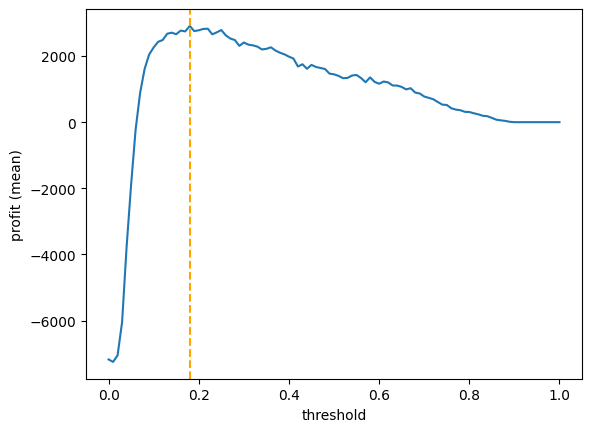

In [965]:
plt.plot(threshold_grid, profits)
plt.ylabel('profit (mean)')
plt.xlabel('threshold')

plt.axvline(x=best_threshold, color='orange', linestyle='--')

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ порог получается в районе 20%. То есть, если человек согласится на предложение хотя бы с вероятностью 20%, его имеет смысл прозванивать. Это имеет смысл в свете того, что мы тратим на звонок 0.2 от возможной выручки. Пусть $Inc$ - прибыль от одного звонка (сл. величина), а $p$ - заранее известная вероятность того, что данный клиент относится к классу соглашающихся. Тогда
$E[Inc] = 10p - 2$. Отсюда очевидно, что клиенту звонить выгодно, если $p \ge 0.2$.

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [977]:
res_best = cross_validate(X, y,
                      n_splits=20,
                      shuffle=True,
                      return_metrics=['profit'],
                      client_max_revenue=20,
                      threshold=0.2)

res_default = cross_validate(X, y,
                             n_splits=20,
                             shuffle=True,
                             return_metrics=['profit'],
                             client_max_revenue=20
)

best_profits = res_best['profit']
default_profits = res_default['profit']

In [978]:
from scipy.stats import ttest_ind
ttest_ind(best_profits, default_profits)

TtestResult(statistic=np.float64(11.854048723632621), pvalue=np.float64(2.4670837811560045e-14), df=np.float64(38.0))

Статистические различия между средними есть на уровне доверия ~100%.

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ макароны с мясом завтрак в 13:00